In [21]:
################# 正式分析脚本 #################
import pandas as pd
import numpy as np
import re
from typing import List, Optional, Union
from elasticsearch import Elasticsearch

es = Elasticsearch(hosts="10.0.1.107", http_auth=("elastic", "8ec1f622cdc1f07c7b21beeeaf8d21f3"), port=9200, timeout=30, max_retries=3, retry_on_timeout=True)

file_paths = [
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1011_1828855(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1011_1828855(2).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1011_1828855(3).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1011_1836221(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1011_1836221(2).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1011_1836221(3).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1012_1822311(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1012_1836223(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1013_1828837(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1013_1828837(2).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1013_1835723(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1013_1835723(2).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1013_1835723(3).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1013_1835723(2).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1015_1835285(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1015_1822327(1).xlsx",
        ]
results = []
subject_name = pd.DataFrame({
    "subject_id": [1010, 1011, 1012, 1013, 1014, 1015],
    "subject_name": ["审计","税法", "经济法", "财管", "会计", "战略"],
})

for idx, path in enumerate(file_paths):
    df = pd.read_excel(path)
    # 模型得分列识别
    model_score_col = None
    for name in ["AI打分", "系统判分", "程序-用户得分"]:
        if name in df.columns:
            model_score_col = name
            break

    # 最小得分点提取函数
    def extract_min_point(row):
        for json_col in ["AI输出", "结果", "程序判分数据"]:
            if json_col in df.columns and isinstance(row.get(json_col), str):
                try:
                    corrected_json_str = row[json_col].replace("null", 'None')
                    corrected_json_str1 =  re.sub(r'\s+', '', corrected_json_str)
                    json_col_res = eval(corrected_json_str1)
                    data = json_col_res
                    try:
                        question_type = data['question_name']
                        scores = [item['scores']['score'] for item in data['correct_answers_scores'] if 'scores' in item and 'score' in item.get('scores', {})]
                        min_score = min(scores) if scores else None
                        lose_points_messages = []
                        # 提取 correct_answers_scores 中非空的 lose_points
                        for item in data.get('student_scores', []):
                            if 'scores' in item and item['scores'].get('lose_points'):
                                for lp in item['scores']['lose_points']:
                                    if 'message' in lp and 'score' in lp:
                                        lose_points_messages.append(f"{lp['message']}_{lp['score']}")
                        lose_point_res = '|'.join(map(str, lose_points_messages)) if lose_points_messages else ''
                        return min_score, lose_point_res, question_type
                    except KeyError as e:
                        print(corrected_json_str)
                        print(f"Key error: {e}")
                        return None, '', ''
                finally:
                    pass
        pattern = re.compile(r"程序-正确.*分值\d*")
        candidates = [row[col] for col in row.index if pattern.match(col) and pd.notna(row[col])]
        return min(candidates) if candidates else None, '', ''

    df[['最小得分点', '失分原因', "判分类型"]] = df.apply(lambda row: extract_min_point(row), axis=1, result_type='expand')

    # 提取指定列
    parsed = df[["科目ID", "用户ID", "试题ID", "试题分数", "判分类型", "boss-用户得分", model_score_col, "最小得分点", "失分原因"]].copy()
    parsed.columns = ["subject_id", "user_id", "question_id", "question_score", "question_type", "teacher_score", "model_score", "min_point", "lose_points"]
    paper_id_info =  path.rsplit('.', 1)[0].rsplit('_', 1)[-1] # re.search(r'_(\d+?)\(', path)
    if paper_id_info:
        # 提取并打印找到的数字
        paper_id = paper_id_info  # paper_id_info.group(1)
        print(f"提取的试卷id是: {paper_id}")
    else:
        paper_id  = 0
        print("没有找到匹配的数字")
    parsed["paper_id"] = paper_id
    results.append(parsed)

def modify_paper_info(row):
    original_str = row['paper_id']
    subject = row['subject_name']
    
    # 检查是否以 (1), (2), 或 (3) 结尾
    if original_str.endswith('(1)'):
        return original_str + '_初版'
    elif (subject == '税法' or subject == '财管'):
        if original_str.endswith('(2)'):
            return original_str + '_正确答案校队'
        elif original_str.endswith('(3)'):
            return original_str + '_修改模型占比'
    
    # 如果不满足上述任何条件，则保持原样
    return original_str

final_df = pd.concat(results, ignore_index=True)
final_df = final_df.merge(subject_name, on="subject_id")
final_df.drop(columns=["subject_id"], inplace=True)
final_df['paper_id'] = final_df.apply(modify_paper_info, axis=1)

提取的试卷id是: 1828855(1)
提取的试卷id是: 1828855(2)
提取的试卷id是: 1828855(3)
提取的试卷id是: 1836221(1)
提取的试卷id是: 1836221(2)
提取的试卷id是: 1836221(3)
提取的试卷id是: 1822311(1)
提取的试卷id是: 1836223(1)
提取的试卷id是: 1828837(1)
提取的试卷id是: 1828837(2)
提取的试卷id是: 1835723(1)
提取的试卷id是: 1835723(2)
提取的试卷id是: 1835723(3)
提取的试卷id是: 1835723(2)
提取的试卷id是: 1835285(1)
提取的试卷id是: 1822327(1)


In [22]:
################# 所有分析函数 ##################
def process_data(df, rule2_quantile=0.95):
    """定义一个通用函数来填充缺失值，并计算三种误差规则"""
    def fill_na_min_point(data):  # 填充缺失的min_point值
        df = data.copy()
        na_rows = df['min_point'].isna()
        for idx in df[na_rows].index:
            qid = df.loc[idx, 'question_id']
            replacement_value = df.loc[df['question_id'] == qid, 'min_point'].dropna().values
            if len(replacement_value) > 0:
                df.at[idx, 'min_point'] = replacement_value[0]
        return df
    
    df1 = fill_na_min_point(df)
    
    # 计算score_error
    df1['score_error'] = df1.apply(lambda row: row['model_score'] - row['teacher_score'], axis=1)
    
    # 规则1: min(question_score * 0.1, min_point)
    df1['accept_error_rule1'] = df1.apply(lambda row: min(row['question_score'] * 0.1, row['min_point']) if not pd.isna(row['min_point']) else (row['question_score'] * 0.1), axis=1)

    # 规则2: 使用分位数（例如：95%）
    rule2_values = df1.groupby(['subject_name', 'paper_id'])['score_error'].quantile(rule2_quantile)
    df1 = df1.merge(rule2_values.rename('accept_error_rule2'), on=['subject_name', 'paper_id'])
    
    # 规则3: 使用均值加减标准差
    group_stats = df1.groupby(['subject_name', 'paper_id'])['score_error'].agg(['mean', 'std'])
    df1 = df1.merge(group_stats, on=['subject_name', 'paper_id'])
    df1['accept_error_rule3'] = df1.apply(lambda x: ("_").join([str(x['mean'] - x['std']), str(x['mean'] + x['std'])]), axis=1)
    df2 = df1.drop(columns=['mean', 'std'], axis=1)
    return df2

def find_group_id(question_list: List[str]) -> Optional[pd.DataFrame]:
    """查找题目的大题ID"""
    body = {
        "query": {
            "terms": {
                "question_id": question_list
            }
        },
        "size": 10,
        "_source": ["group_id", "question_id"]
    }
    response = es.search(index='biz_question_v2', body=body)
    if not response['hits']['total']['value']:
        return None
    return pd.DataFrame([hit['_source'] for hit in response['hits']['hits']])

def get_group_ques_df(df):
    """从小题层面聚合提取大题层面数据"""
    question_list = df['question_id'].unique().tolist()
    group_df = find_group_id(question_list)
    
    if group_df is not None:
        df1 = df.merge(group_df, on='question_id', how='left')
        df1['group_id'] = df1.apply(
            lambda x: int(x['group_id']) if pd.notna(x['group_id']) else int(x['question_id']),
            axis=1
        )
    else:
        df1 = df.copy()
        df1['group_id'] = df1['question_id'].astype(int)
    
    agg_dict = {
        'question_score': 'sum',
        'question_type': 'unique',
        'teacher_score': 'sum',
        'model_score': 'sum',
        'min_point': 'sum'
    }
    
    df2 = df1.groupby(['subject_name', 'paper_id', 'user_id', 'group_id']).agg(agg_dict).reset_index()
    df2.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in df2.columns.values]
    df2.rename(columns={
        'subject_name_': 'subject_name',
        'paper_id_': 'paper_id',
        'user_id_': 'user_id',
        'group_id_': 'group_id',
        'question_score_sum': 'question_score',
        'question_type_unique': 'question_score',
        'teacher_score_sum': 'teacher_score',
        'model_score_sum': 'model_score',
        'min_point_sum': 'min_point'
    }, inplace=True)
    
    return df2

def process_dataframe(df, exclude_columns):
    """将结果转换成百分比"""
    for col in df.columns:
        if col not in exclude_columns:
            # 执行乘以100，四舍五入到两位小数
            df[col] = (df[col] * 100).round(2)
            # 将结果转换为字符串并加上百分号
            df[col] = df[col].astype(str) + '%'
    result = df.reset_index(drop=True)
    
    return result

def stats_describe(df):
    """计算误差描述统计量"""
    error_stats_ques = df.groupby(['subject_name', 'paper_id'])['score_error'].agg([
        ('平均误差', 'mean'),
        ('误差中位数', 'median'),
        ('误差标准差', 'std'),
        ('最小误差', 'min'),
        ('最大误差', 'max'),
        ('误差绝对值均值', lambda x: x.abs().mean()),
        ('25%分位数', lambda x: x.quantile(0.25)),
        ('75%分位数', lambda x: x.quantile(0.75)),
        ('95%分位数', lambda x: x.quantile(0.95))
    ]).reset_index(drop=False)
    return error_stats_ques

def calculate_percentage_within_margin(prob: float, group: pd.DataFrame) -> float:
    """计算误差在给定百分比范围内的比例"""
    lower_bound = -prob * group['question_score']
    upper_bound = prob * group['question_score']
    within_margin = ((group['score_error'] >= lower_bound) & (group['score_error'] <= upper_bound))
    return within_margin.mean()

def classify_error(error: float) -> str:
    """分类误差类型"""
    if error == 0:
        return '完全匹配'
    return '模型偏高' if error > 0 else '模型偏低'
    
def is_precise_match(error: float, acceptable_error: Union[float, str], rule_type: int) -> bool:
    """检查是否为精准匹配"""
    if rule_type == 3:
        lower_bound, upper_bound = map(float, acceptable_error.split('_'))
        return lower_bound <= error <= upper_bound
    return -acceptable_error <= error <= acceptable_error

def calculate_percentage_error(row: pd.Series, percentage: float) -> bool:
    """计算误差是否在给定百分比范围内"""
    question_score = row['question_score']
    score_error = row['score_error']
    margin = question_score * percentage / 100.0
    return -margin <= score_error <= margin

def _calculate_common_metrics(grouped_data: pd.core.groupby.generic.DataFrameGroupBy, group_key: List[str]) -> pd.DataFrame:
    """计算通用指标（内部函数）"""
    # 初始化结果DataFrame
    stats = grouped_data.size().reset_index(name='count')
    
    # 计算各类误差比例
    error_classes = grouped_data['error_class'].value_counts(normalize=True).unstack().fillna(0)
    stats = stats.merge(error_classes, left_on=group_key, right_index=True)
    
    # 计算精准匹配的比例（针对三种规则）
    for rule_num in [1, 2, 3]:
        stats[f'精准匹配{rule_num}'] = grouped_data[f'is_precise_match_{rule_num}'].mean().values
    
    # 统计不同误差范围内的比例
    error_ranges = {
        '误差0.5内': (-0.5, 0.5),
        '误差0.8内': (-0.8, 0.8),
        '误差1内': (-1, 1)
    }
    
    for name, (lower, upper) in error_ranges.items():
        stats[name] = grouped_data['score_error'].apply(
            lambda x: ((x >= lower) & (x <= upper)).mean()
        ).values
    
    # 添加误差分值5%、10%、15%内的比例
    for percent in [5, 10, 15]:
        column_name = f'误差分值{percent}%内'
        stats[column_name] = grouped_data.apply(
            lambda g: g.apply(calculate_percentage_error, percentage=percent, axis=1).mean()
        ).values
    
    stats['老师0分_模型给分'] = grouped_data.apply(
        lambda g: ((g['teacher_score'] == 0) & (g['model_score'] > 0)).mean()
    ).values
    
    # 新增指标：老师给分但模型打0分的数据占比
    stats['老师给分_模型0分'] = grouped_data.apply(
        lambda g: ((g['teacher_score'] > 0) & (g['model_score'] == 0)).mean()
    ).values
    
    return stats.drop(columns=['count'])

def analyze_paper_scores(df: pd.DataFrame) -> pd.DataFrame:
    """分析试卷得分"""
    # 转换数据类型
    df['question_score'] = pd.to_numeric(df['question_score'], errors='coerce')
    df['score_error'] = pd.to_numeric(df['score_error'], errors='coerce')
    
    # 移除无效数据
    df = df.dropna(subset=['question_score', 'score_error'])
    
    # 应用分类
    df['error_class'] = df['score_error'].apply(classify_error)
    
    # 针对三种规则分别计算精准匹配
    for rule_num in [1, 2, 3]:
        df[f'is_precise_match_{rule_num}'] = df.apply(
            lambda x: is_precise_match(x['score_error'], x[f'accept_error_rule{rule_num}'], rule_num),
            axis=1
        )
    
    # 按试卷分组并计算指标
    return _calculate_common_metrics(df.groupby(['subject_name','paper_id']), ['subject_name', 'paper_id'])

def analyze_by_student_level(df: pd.DataFrame) -> pd.DataFrame:
    """按学生试卷分数段水平分析"""
    # 计算每份试卷的满分
    paper_full_scores = df.drop_duplicates(['subject_name', 'paper_id', 'question_id'])\
                         .groupby(['subject_name', 'paper_id'])['question_score'].sum()\
                         .reset_index(name='full_score')
    
    # 合并回原始数据
    df = df.merge(paper_full_scores, on=['subject_name', 'paper_id'])
    
    # 计算每个学生在每份试卷上的总分
    student_scores = df.groupby(['subject_name', 'paper_id', 'user_id']).agg({
        'teacher_score': 'sum',
        'model_score': 'sum',
        'full_score': 'first'
    }).reset_index()
    
    # 划分等级
    def classify_student(row: pd.Series) -> str:
        ratio = row['teacher_score'] / row['full_score']
        if ratio >= 0.7:
            return '70%以上'
        return '30%~70%' if ratio >= 0.3 else '30%以下'
    
    student_scores['level'] = student_scores.apply(classify_student, axis=1)
    
    # 合并等级信息回原始数据
    df = df.merge(student_scores[['subject_name', 'paper_id', 'user_id', 'level']], 
                 on=['subject_name', 'paper_id', 'user_id'])
    
    # 应用分类
    df['error_class'] = df['score_error'].apply(classify_error)
    
    # 针对三种规则分别计算精准匹配
    for rule_num in [1, 2, 3]:
        df[f'is_precise_match_{rule_num}'] = df.apply(
            lambda x: is_precise_match(x['score_error'], x[f'accept_error_rule{rule_num}'], rule_num),
            axis=1
        )
    
    # 按试卷和等级分组并计算指标
    level_stats = _calculate_common_metrics(df.groupby(['subject_name', 'paper_id', 'level']), 
                                           ['subject_name', 'paper_id', 'level'])
    
    # 将 level 转换为有序分类并排序
    level_order = ['70%以上', '30%~70%', '30%以下']
    level_stats['level'] = pd.Categorical(level_stats['level'], categories=level_order, ordered=True)
    return level_stats.sort_values(['subject_name', 'paper_id', 'level']).reset_index(drop=True)

In [23]:
######## 主流程
def analyze_and_describe(df, group_keys):
    """
    分析数据并描述统计数据。
    """
    acc_stats = analyze_paper_scores(df)
    stats = stats_describe(df)
    processed_acc_stats = process_dataframe(acc_stats, group_keys)
    return processed_acc_stats, stats

# step1：数据处理--误差计算
final_df1 = process_data(final_df)
final_group_df1 = process_data(get_group_ques_df(final_df))

# step2：准确率计算
ques_acc_stats, error_stats_ques = analyze_and_describe(final_df1, ['subject_name', 'paper_id'])
group_acc_stats, error_stats_group = analyze_and_describe(final_group_df1, ['subject_name', 'paper_id'])
# level_stats, _ = analyze_and_describe(final_df1, ['subject_name', 'paper_id', "level"])

In [27]:
# 对数据进行一定的清洗过滤后计算准确率
# step1：先筛选每个科目最新的一份试卷数据
sub_paper_newest = ques_acc_stats[['subject_name',"paper_id"]].drop_duplicates()
sub_paper_newest1 = sub_paper_newest.copy()
sub_paper_newest1['paper_id_info'] = sub_paper_newest1['paper_id'].str.split('(', n=1).str[0]
sub_paper_newest2 = sub_paper_newest1.groupby(['subject_name', 'paper_id_info']).apply(lambda x: x.sort_values('paper_id',ascending=False).head(1))

# step2: 根据一定的规则对数据进行过滤
def filter_and_process_data(df_raw, paper_range, condition):
    """
    根据给定条件过滤数据并处理。
    """
    df_case = df_raw.copy()
    df_case1 = df_case[df_case['paper_id'].isin(paper_range)]
    if condition:
        # 筛选规则1：财管中表格类型、模型判0分的数据踢掉
        df_deal = df_case1.copy()
        df_filtered = df_deal[~((df_deal['question_type'] == '表格') & (df_deal['model_score'] == 0))] 
        
        # 筛选规则2：战略中lose_points为“正确答案已经全部匹配”的数据误差改为0
        df_filtered1 = df_filtered.copy()
        df_filtered1['is_correct_fitted'] = df_filtered1.apply(lambda x: 1 if ('正确答案已经全部匹配' in x['lose_points'] and x['subject_name'] == '战略') else 0, axis=1)
        
        # 筛选规则3：错误类型只包含单位错误的数据的误差改为0
        def check_unit_error_only(lose_points):
            # 使用正则表达式匹配仅包含“单位错误”的情况
            if re.fullmatch(r'(?:单位错误_.+?)(?:\|单位错误_.+?)*', lose_points):
                return 1
            else:
                return 0
        df_filtered2 = df_filtered1.copy()
        df_filtered2["is_unit_error"] = df_filtered2['lose_points'].apply(check_unit_error_only)
        
        # 修改符合筛选规则数据的误差值        
        df_filtered2['model_score'] = df_filtered2.apply(lambda x: x['teacher_score'] if x['is_correct_fitted'] == 1 or x['is_unit_error'] == 1 else x['model_score'], axis=1)
        df_filtered_res = df_filtered2.drop(columns=['is_correct_fitted', 'is_unit_error'], axis=1)
    else:
        df_filtered_res = df_case1.copy()
    return df_filtered_res

# step3: 计算准确率
paper_range = sub_paper_newest2['paper_id'].unique().tolist()
final_df1_adj = process_data(filter_and_process_data(final_df, paper_range, condition=True))
final_group_df1_adj = process_data(get_group_ques_df(final_df1_adj))
ques_acc_stats_adj, error_stats_ques_adj = analyze_and_describe(final_df1_adj, ['subject_name', 'paper_id'])
group_acc_stats_adj, error_stats_group_adj = analyze_and_describe(final_group_df1_adj, ['subject_name', 'paper_id'])


In [28]:
def analyze_paper_scores_with_unit_error(original_df: pd.DataFrame, new_df: pd.DataFrame) -> pd.DataFrame:
    """分析包含单元错误的试卷得分
    
    参数:
        original_df: 原始数据(不包含is_unit_error列)
        new_df: 新数据(包含is_unit_error列)
    
    返回:
        考虑单元错误调整后的统计结果
    """
    # 1. 首先处理原始数据，获取基准指标
    original_stats = analyze_paper_scores(original_df)
    
    # 2. 准备新数据
    # 转换数据类型
    new_df['question_score'] = pd.to_numeric(new_df['question_score'], errors='coerce')
    new_df['score_error'] = pd.to_numeric(new_df['score_error'], errors='coerce')
    new_df['is_unit_error'] = new_df['is_unit_error'].astype(int)  # 确保是整数类型
    
    # 移除无效数据
    new_df = new_df.dropna(subset=['question_score', 'score_error'])
    
    # 应用分类
    new_df['error_class'] = new_df['score_error'].apply(classify_error)
    
    # 3. 定义计算调整后指标的函数
    def calculate_adjusted_metric(group, original_metrics):
        group_key = (group.name[0], group.name[1])  # (subject_name, paper_id)
        
        try:
            original_row = original_metrics.loc[group_key]
        except KeyError:
            # 如果没有找到原始数据，则按常规方式计算
            return _calculate_common_metrics(group.to_frame().groupby(['subject_name', 'paper_id']), 
                                           ['subject_name', 'paper_id'])
        
        # 获取组内记录数
        count = len(group)
        
        # 初始化结果字典
        result = {}
        
        # 处理固定误差范围指标
        error_ranges = {
            '误差0.5内': (-0.5, 0.5),
            '误差0.8内': (-0.8, 0.8),
            '误差1内': (-1, 1)
        }
        
        for name, (lower, upper) in error_ranges.items():
            original_percent = original_row[name]
            original_count = round(original_percent * count)
            
            # 找出原始不在范围内但is_unit_error=1的记录
            additional = ((~((group['score_error'] >= lower) & (group['score_error'] <= upper))) & (group['is_unit_error'] == 1))
            additional_count = additional.sum()
            
            result[name] = (original_count + additional_count) / count
        
        # 处理百分比误差指标
        for percent in [5, 10, 15]:
            name = f'误差分值{percent}%内'
            original_percent = original_row[name]
            original_count = round(original_percent * count)
            
            # 计算原始不在范围内但is_unit_error=1的记录
            percentage_errors = group.apply(calculate_percentage_error, percentage=percent, axis=1)
            additional = (~percentage_errors) & (group['is_unit_error'] == 1)
            additional_count = additional.sum()
            
            result[name] = (original_count + additional_count) / count
        
        # 处理特殊指标
        special_metrics = ['老师0分_模型给分', '老师给分_模型0分']
        for metric in special_metrics:
            if metric in original_row:
                original_percent = original_row[metric]
                original_count = round(original_percent * count)
                
                if metric == '老师0分_模型给分':
                    condition = (group['teacher_score'] == 0) & (group['model_score'] > 0)
                else:
                    condition = (group['teacher_score'] > 0) & (group['model_score'] == 0)
                
                additional = (~condition) & (group['is_unit_error'] == 1)
                additional_count = additional.sum()
                
                result[metric] = (original_count + additional_count) / count
        
        # 处理error_class指标
        if 'error_class' in group:
            error_classes = group['error_class'].value_counts(normalize=True).to_dict()
            for cls, val in error_classes.items():
                result[f'{cls}'] = val
        
        return pd.Series(result)
    
    # 4. 应用调整后的计算
    # 将原始统计结果转为MultiIndex方便查询
    original_stats_multi = original_stats.set_index(['subject_name', 'paper_id'])
    
    # 分组计算调整后指标
    adjusted_stats = new_df.groupby(['subject_name', 'paper_id']).apply(
        lambda g: calculate_adjusted_metric(g, original_stats_multi)
    ).reset_index()
    adjusted_stats.columns = ['subject_name', 'paper_id', "metric", "prob"]
    
    # 重新排列列顺序以匹配原始格式
    df_wide = adjusted_stats.pivot_table(index=['subject_name', 'paper_id'],  
                                        columns='metric', values='prob').reset_index()
    # 重新排列列顺序以匹配原始格式
    adjusted_stats_res = df_wide[original_stats.columns]
    return adjusted_stats_res.reset_index(drop=True)

# final_df2 = final_df1.copy()
# final_df2['is_unit_error'] = final_df2.apply(lambda x: 1 if '正确答案已经全部匹配' in x['lose_points'] else 0, axis=1)
# result = analyze_paper_scores_with_unit_error(final_df1, final_df2)

In [29]:
# 合并数据：left join 保留原始顺序
def format_colored(row, col):
    raw_val = row[col]
    filtered_val = row[f"{col}_filtered"]
    if pd.isnull(filtered_val):
        return raw_val  # 没有过滤后数据

    # 转换为数值（去掉百分号）
    raw_num = float(str(raw_val).replace('%', ''))
    filtered_num = float(str(filtered_val).replace('%', ''))

    # 比较并添加颜色
    if abs(raw_num - filtered_num) < 1e-6:
            return raw_val  # 无变化

    color = "green" if filtered_num > raw_num else "red"
    return f'{raw_val} <span style="color:{color}">（{filtered_val}）</span>'

def merge_more_accurate(df_raw, df_filter):
    key_cols = ['subject_name', 'paper_id']
    df_merged = df_raw.merge(df_filter, on=key_cols, suffixes=('', '_filtered'), how='left')

    # 拼接百分比字段
    accuracy_cols = [col for col in df_raw.columns if col not in key_cols]

    # 应用格式化
    for col in accuracy_cols:
        df_merged[col] = df_merged.apply(lambda row: format_colored(row, col), axis=1)

    # 保留最终列
    df_final = df_merged[key_cols + accuracy_cols]
    return df_final

ques_acc_stats_raw = ques_acc_stats[ques_acc_stats['paper_id'].isin(paper_range)].copy()
group_acc_stats_raw = group_acc_stats[group_acc_stats['paper_id'].isin(paper_range)].copy()
 
ques_acc_compare = merge_more_accurate(ques_acc_stats_raw, ques_acc_stats_adj)
group_acc_compare = merge_more_accurate(group_acc_stats_raw, group_acc_stats_adj)

In [30]:
# 定义表格数据html格式处理函数

from IPython.display import HTML
import pandas as pd

def styled_group_table(df: pd.DataFrame, subject_col='科目名称') -> str:
    # 确保不会修改原始 df
    df1 = df.copy()

    # 获取每个科目（subject_name）组的最后一行的索引
    subject_series = df1[subject_col]
    is_last_of_group = subject_series != subject_series.shift(-1)  # 最后一行标记
    is_first_of_group = subject_series != subject_series.shift(1)  # 第一行标记

    # 清除非首行的科目名称
    df1.loc[~is_first_of_group, subject_col] = ''

    # 创建 HTML 表格
    html = """
    <style>
        th, td { text-align: center; padding: 6px; }
        th { border-bottom: 2px solid black; }
        .group-end td { border-bottom: 2px solid #333; } /* 仅在最后一行添加下框线 */
        table { border-collapse: collapse; width: 100%; margin-top: 10px; }
    </style>
    """
    
    # 表格开头
    html += '<table><thead><tr>'
    html += ''.join(f'<th>{col}</th>' for col in df1.columns)
    html += '</tr></thead><tbody>'

    # 逐行生成表格
    for i in range(len(df1)):
        row = df1.iloc[i]
        # 如果是最后一行，则添加下框线
        row_class = 'group-end' if is_last_of_group.iloc[i] else ''
        html += f'<tr class="{row_class}">' + ''.join(f'<td>{row[col]}</td>' for col in df1.columns) + '</tr>'

    # 结束标签
    html += '</tbody></table>'
    
    return html

def format_floats_smart(df: pd.DataFrame, skip_cols=2) -> pd.DataFrame:
    df1 = df.copy()
    num_cols = df1.select_dtypes(include='number').columns.tolist()
    format_cols = df1.columns[skip_cols:]  # 从第 skip_cols 列之后开始格式化

    for col in format_cols:
        if col in num_cols:
            df1[col] = df1[col].apply(lambda x: f"{x:.3f}".rstrip('0').rstrip('.') if pd.notnull(x) else '')
    return df1

def process_dataframe(df, skip_cols=2):
    """统一处理数据框：格式化浮点数并重命名列"""
    formatted_df = format_floats_smart(df, skip_cols=skip_cols)
    formatted_df.rename(columns={'subject_name': '科目名称', 'paper_id': '试卷ID'}, inplace=True)
    return formatted_df

In [31]:
########## 表格html结果 #########
dataframes = {
    'html_ques_error': (error_stats_ques, 2),
    'html_group_error': (error_stats_group, 2),
    'html_ques_acc': (ques_acc_stats, 2),
    'html_group_acc': (group_acc_stats, 2),
    'compare_ques_acc': (ques_acc_compare, 2),
    'compare_group_acc': (group_acc_compare, 2),
}

# 使用字典推导式处理所有数据框
processed = {name: styled_group_table(process_dataframe(df, skip_cols)) 
             for name, (df, skip_cols) in dataframes.items()}

# 构建最终HTML列表
table_html_list = [
    "<h2>试卷整体误差统计描述</h2>",
    "<p>下面表格是从小题和大题（某些小题同属于一个大题组）两个层面统计的关于老师打分和模型打分之间分差的描述统计量</p>",
    "<h3>小题层面</h3>" + processed['html_ques_error'],
    "<h3>大题层面</h3>" + processed['html_group_error'],
    
    "<h2>判分准确性分析</h2>",
    """<div class="description">
        <p>以下是从多个角度统计的模型判分准确性指标，其中精准匹配1/2/3是根据一下三种规则得到一个误差合理值或者误差合理范围，然后统计的分差在对应误差范围内的数据占比。规则如下：<br>
           规则1：取题目最小得分点和该题目分值的10%两者之间的最小值；<br>
           规则2：分差的百分之95%分位数；<br>
           规则3：获取分差均值和标准差，计算均值正负一个标准差范围。</p>
    </div>""",
    "<h3>小题层面</h3>" + processed['html_ques_acc'],
    "<h3>大题层面</h3>" + processed['html_group_acc'],
    
    "<h2>按规则筛选数据后准确性结果</h2>",
    """<div class="description">
        <p>以下结果是根据题目判分类型和观察模型判定错误类型及数据后总结的一些筛选规则，根据规则筛选出来的数据暂时认定为是模型判断无误的数据。<br>
        表格展示的是小题和大题层面，各科目最终版本数据的各项指标准确率和基于最终版本和筛选条件后计算的准确率结果的对比。<br>
        黑色代表两者准确率没有差异，红色代表处理后数据的准确率下降，绿色代表处理后数据的准确率上升。<br>
           筛选条件1：剔除财管中题目类型为“表格”且模型判分为0的数据（可能是学生答案没填在表格里，没法判）；<br>
           筛选条件2：财管中如果某个小题错误类型都是单位错误，暂时认定该题目模型打分和老师判分没分差；<br>
           筛选条件3：战略中有错误类型包含“正确答案已经全部匹配”字样，暂时认定该题目模型打分和老师判分没分差</p>
    </div>""",
    "<h3>小题层面</h3>" + processed['compare_ques_acc'],
    "<h3>大题层面</h3>" + processed['compare_group_acc'],
]

In [32]:
########### 绘图相关函数 ##########
import os
import matplotlib.pyplot as plt
from IPython.display import HTML
from pathlib import Path
import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec

matplotlib.rcParams['font.family'] = ['SimHei']           # 使用黑体显示中文
matplotlib.rcParams['axes.unicode_minus'] = False         # 正确显示负号

def create_kde_plot(ax, data, title, STYLE):
    """通用KDE绘图函数"""
    if not data.empty:
        for role in ['teacher', 'model']:
            color, label = STYLE['colors'][role]
            sns.kdeplot(data[f'{role}_score'], ax=ax, 
                        label=label, color=color, 
                        fill=True, warn_singular=False)
        ax.set_title(title, fontsize=STYLE['subtitle_fontsize'])
        ax.set_xlabel("得分", fontsize=STYLE['label_fontsize'])
        ax.set_ylabel("密度", fontsize=STYLE['label_fontsize'])
        ax.legend(fontsize=STYLE['legend_fontsize'])
        ax.tick_params(axis='both', labelsize=STYLE['tick_fontsize'])
    else:
        ax.axis('off')

def build_grid_plot(df, groupby_col, title, filename, STYLE, output_dir):
    """通用网格绘图函数"""
    # 准备数据
    subjects = sorted(df['subject_name'].unique())
    group_dict = {
        subj: sorted(df[df['subject_name'] == subj][groupby_col].unique())
        for subj in subjects
    }
    max_cols = max(len(v) for v in group_dict.values())
    
    # 创建画布
    fig = plt.figure(
        figsize=(STYLE['col_width'] * max_cols, 
                STYLE['row_height'] * len(subjects)),
        constrained_layout=True
    )
    outer = gridspec.GridSpec(
        len(subjects), 1, 
        height_ratios=[1]*len(subjects), 
        hspace=STYLE['hspace']
    )

    # 绘制子图
    for row_idx, subject in enumerate(subjects):
        groups = group_dict[subject]
        inner = gridspec.GridSpecFromSubplotSpec(
            1, len(groups), 
            subplot_spec=outer[row_idx], 
            wspace=STYLE['wspace']
        )
        
        for k, group_val in enumerate(groups):
            ax = plt.Subplot(fig, inner[k])
            sub_df = df[(df['subject_name'] == subject) & 
                        (df[groupby_col] == group_val)]
            
            # 动态生成标题
            if groupby_col == 'paper_id':
                plot_title = f"{subject} | 试卷: {group_val} | n={len(sub_df)}"
            elif groupby_col == 'question_score':
                plot_title = f"{subject} | 满分 {group_val} 分\nn={len(sub_df)}"
            else:
                plot_title = f"{subject} | 题型: {group_val}\nn={len(sub_df)}"
            
            create_kde_plot(ax, sub_df, plot_title, STYLE)
            fig.add_subplot(ax)

    plt.suptitle(title, fontsize=STYLE['title_fontsize'], y=0.98)
    plt.savefig(output_dir / filename, bbox_inches='tight', dpi=STYLE['dpi'])
    return output_dir / filename


C:\Users\xxxlll\AppData\Local\Temp\ipykernel_38120\1684041940.py:77: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(output_dir / filename, bbox_inches='tight', dpi=STYLE['dpi'])
C:\Users\xxxlll\AppData\Local\Temp\ipykernel_38120\1684041940.py:77: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(output_dir / filename, bbox_inches='tight', dpi=STYLE['dpi'])
C:\Users\xxxlll\AppData\Local\Temp\ipykernel_38120\1684041940.py:77: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(output_dir / filename, bbox_inches='tight', dpi=STYLE['dpi'])


✅ 报告已生成：C:\Users\xxxlll\Desktop\东奥\subjective_judge_score\report_output\report.html


c:\Users\xxxlll\AppData\Local\conda\conda\envs\pytorch\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


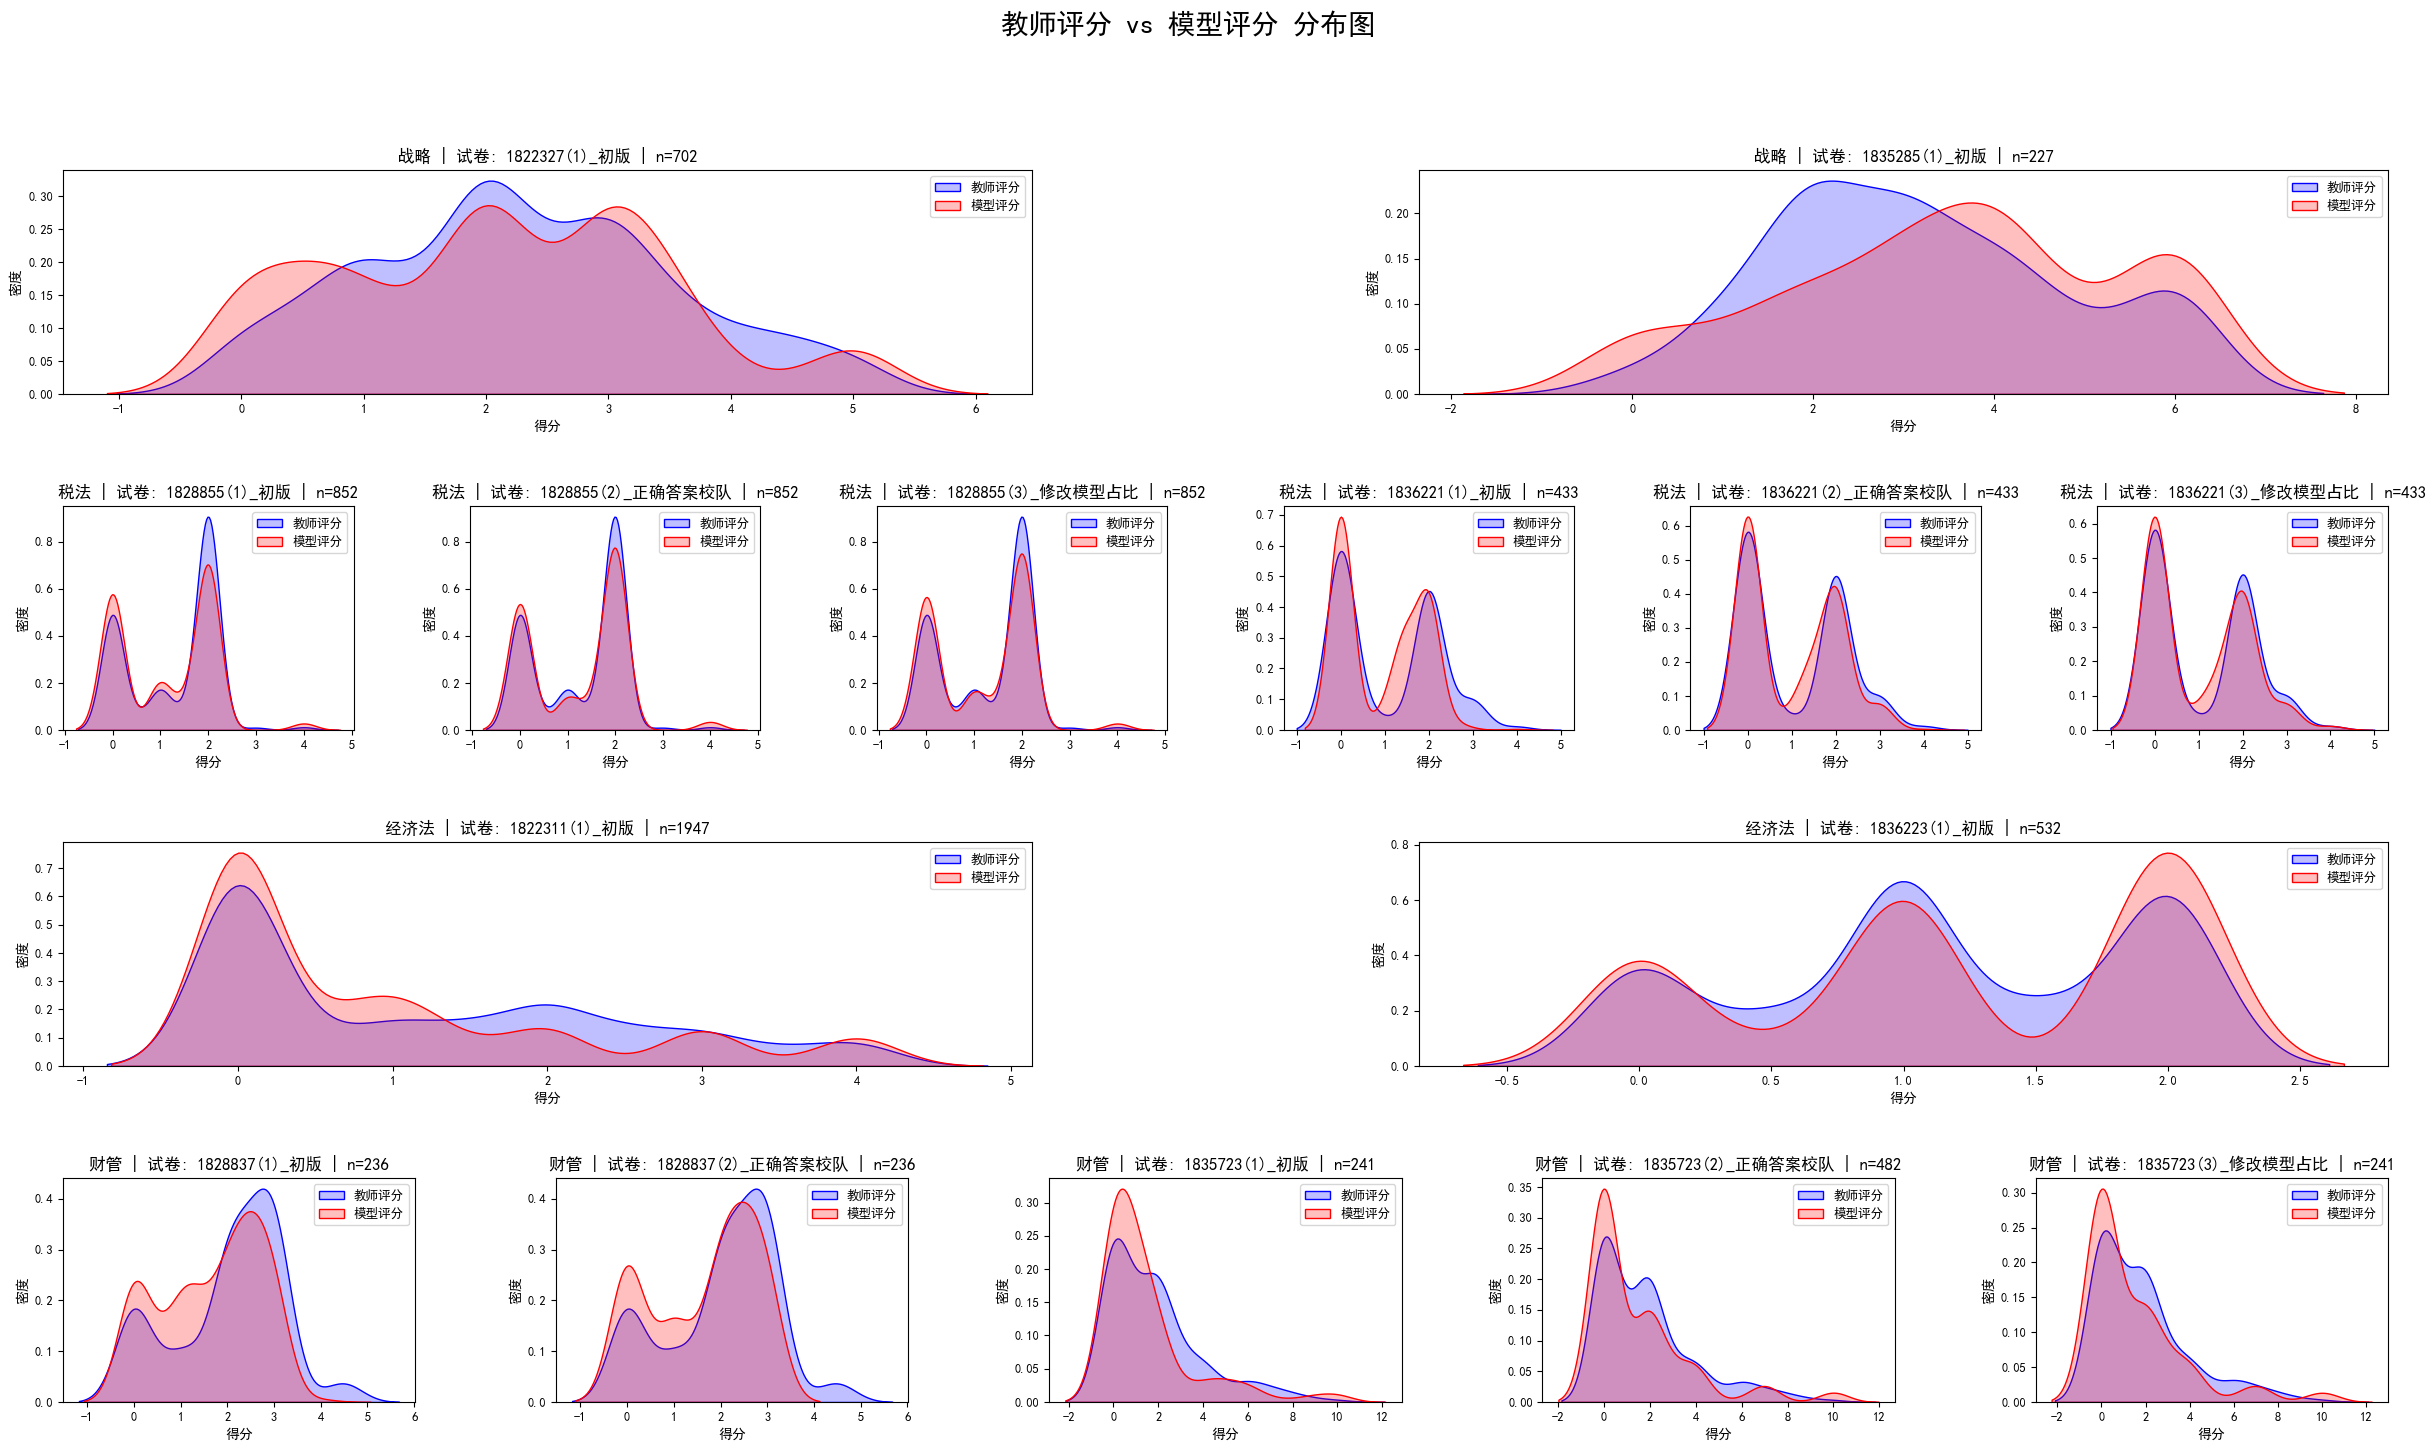

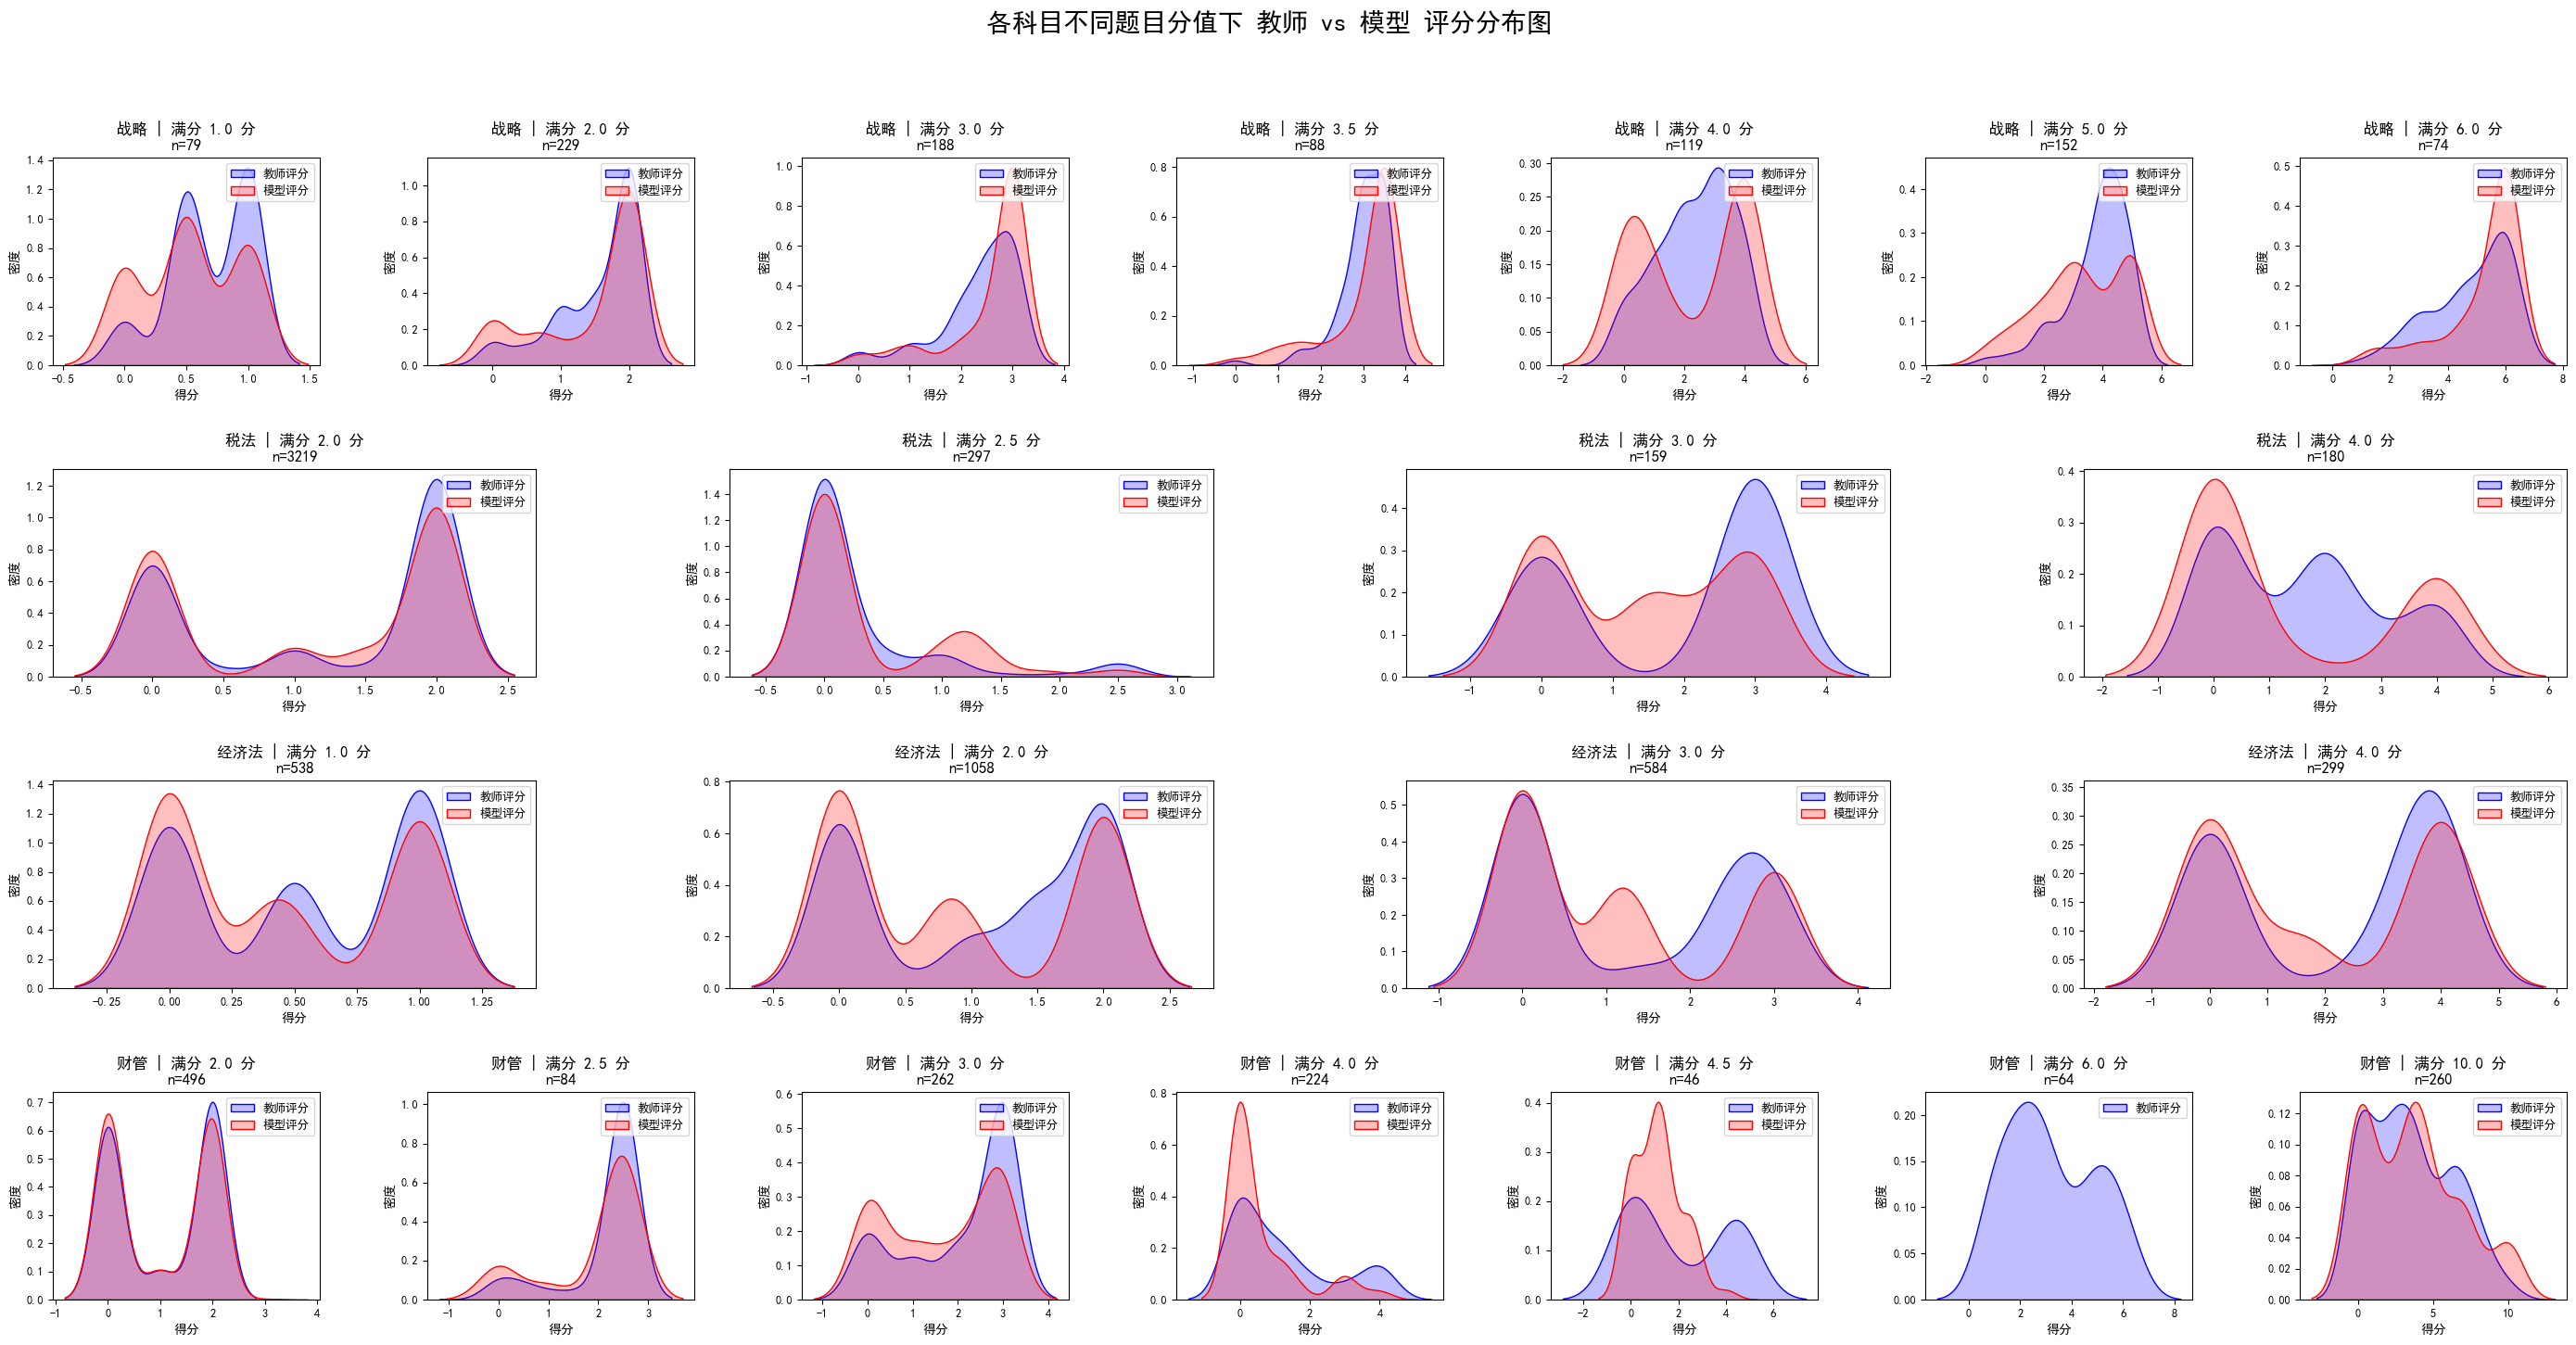

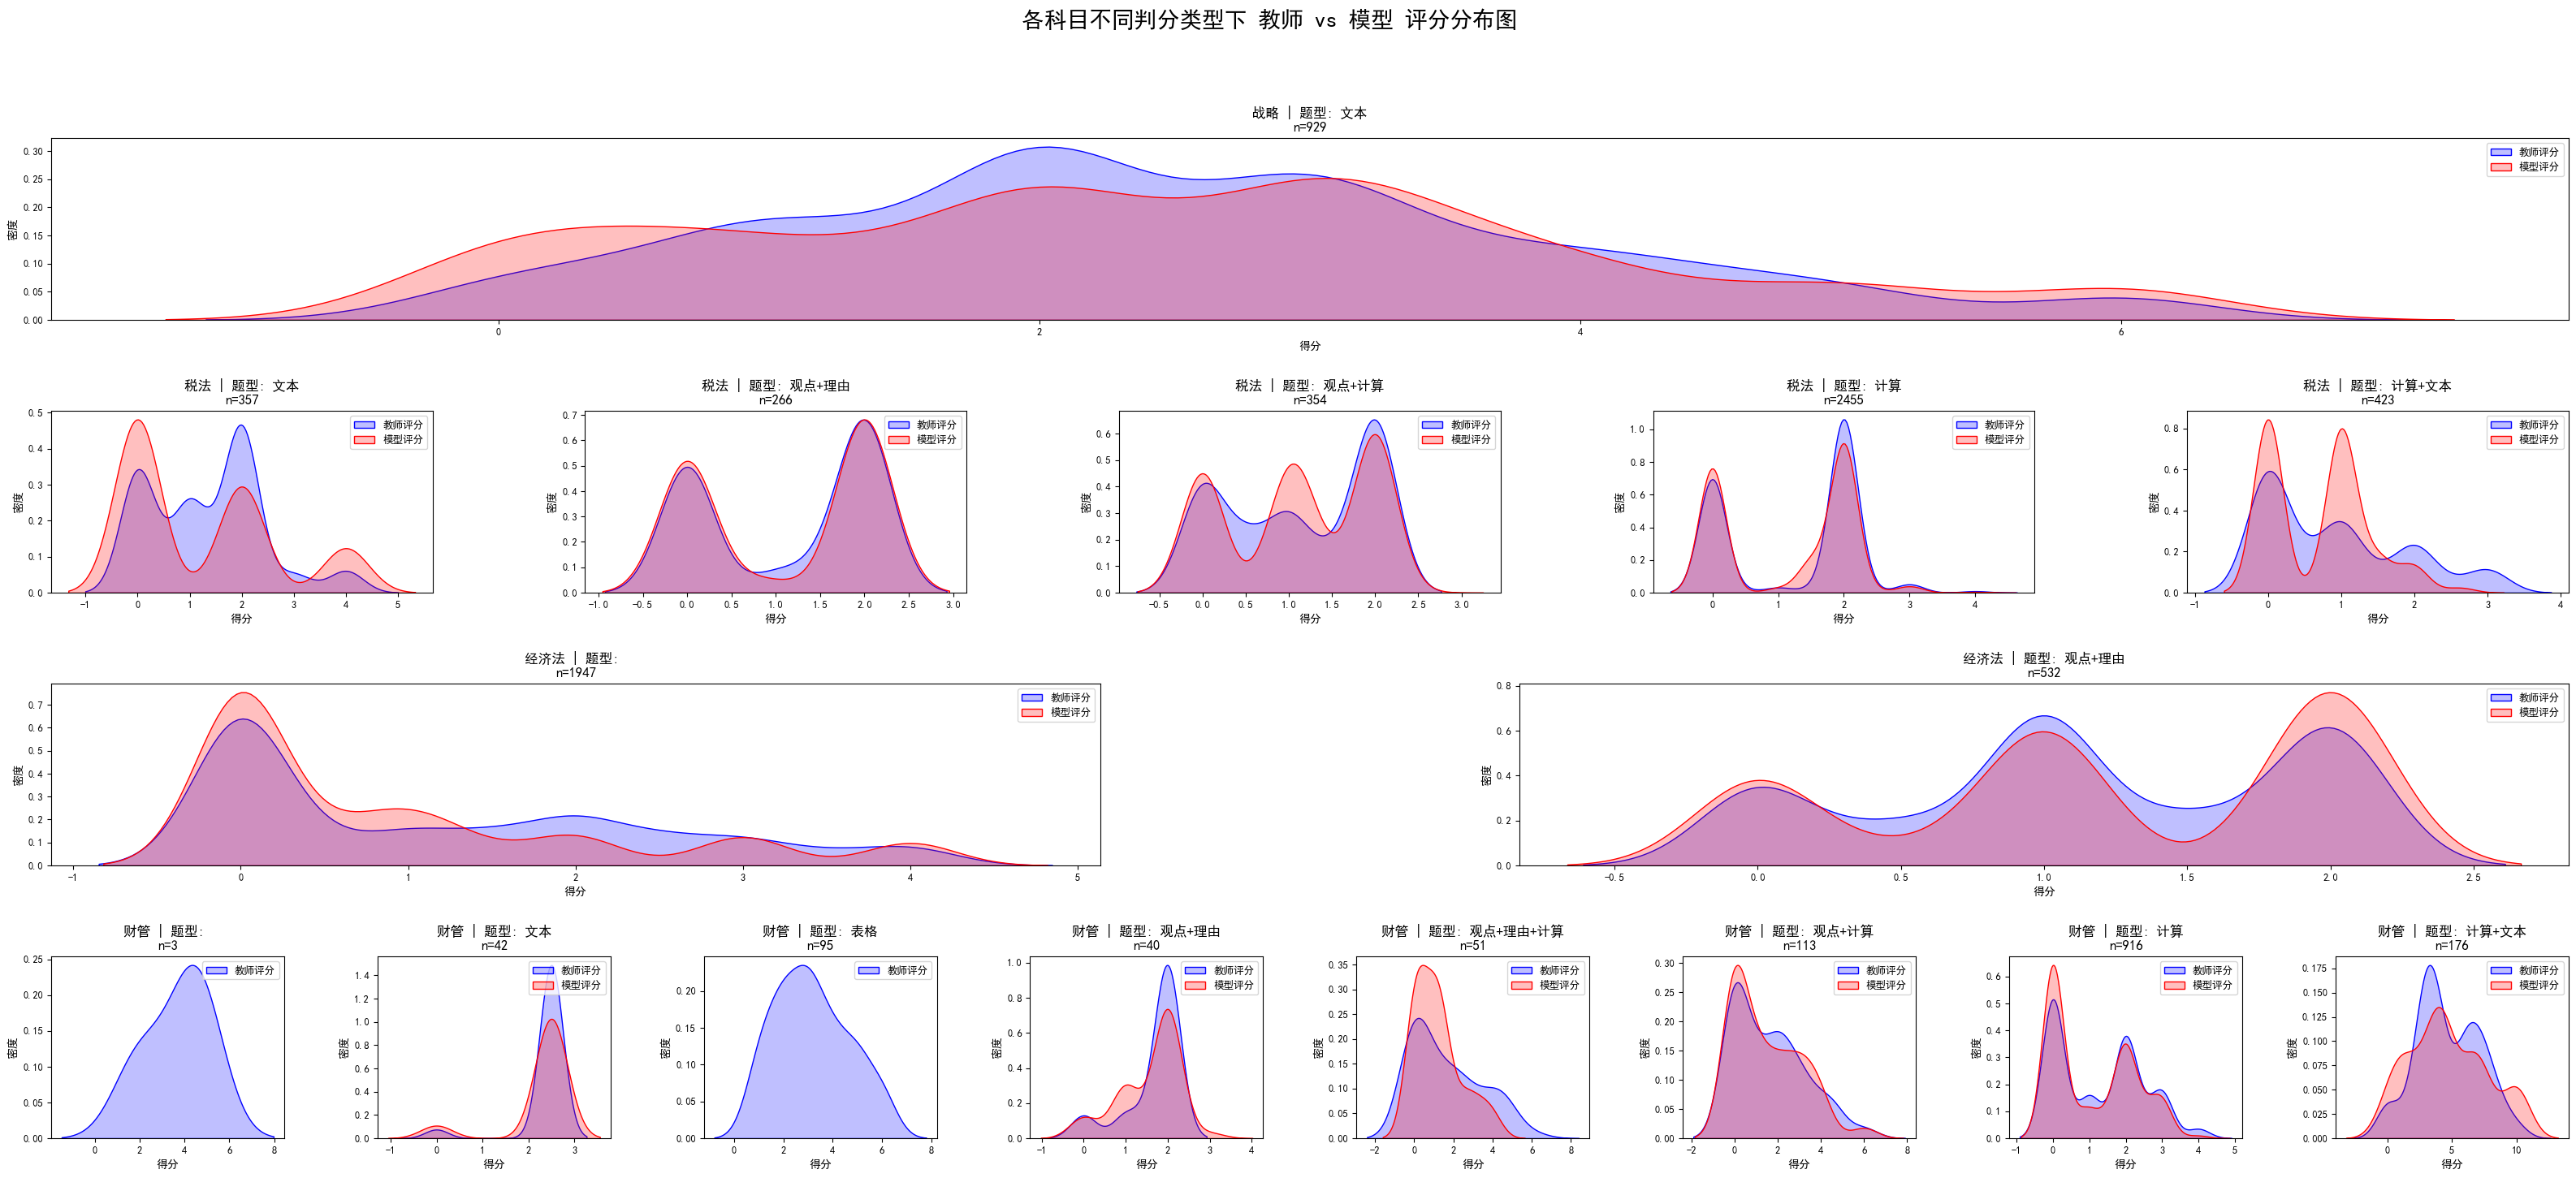

In [33]:
########### 生成html文件 ##############

# 设置输出目录
output_dir = Path("report_output")
output_dir.mkdir(exist_ok=True)

# 1. 保存所有图像
def save_all_figures(final_df1):
    """保存三种评分分布对比图"""
    # 常量定义（统一调整所有图表参数）
    STYLE = {
        'row_height': 4,          # 每行高度
        'col_width': 5,           # 每列宽度
        'title_fontsize': 20,      # 主标题字号
        'subtitle_fontsize': 12,   # 子标题字号
        'label_fontsize': 10,      # 轴标签字号
        'legend_fontsize': 9,      # 图例字号
        'tick_fontsize': 9,        # 刻度字号
        'hspace': 0.5,            # 行间距
        'wspace': 0.4,            # 列间距
        'dpi': 300,               # 输出分辨率
        'colors': {               # 颜色配置
            'teacher': ('blue', '教师评分'),
            'model': ('red', '模型评分')
        }
    }

    # 主流程
    fig_paths = []
    df = final_df1.copy()
    df1 = df
    
    # 图表1：按试卷分布
    fig_paths.append(
        build_grid_plot(
            df, 'paper_id',
            "教师评分 vs 模型评分 分布图",
            "fig_score_dist_by_paper.png",
            STYLE,
            output_dir
        )
    )
    
    # 图表2：按题目分值分布
    fig_paths.append(
        build_grid_plot(
            df, 'question_score',
            "各科目不同题目分值下 教师 vs 模型 评分分布图",
            "fig_score_dist_by_question_score.png",
            STYLE,
            output_dir
        )
    )
    
    # 图表3：按判分类型分布
    fig_paths.append(
        build_grid_plot(
            df, 'question_type',
            "各科目不同判分类型下 教师 vs 模型 评分分布图",
            "fig_score_dist_by_question_type.png",
            STYLE,
            output_dir
        )
    )

    #    # 图表3：按判分类型分布
    # fig_paths.append(
    #     build_grid_plot(
    #         df, 'question_type',
    #         "各科目不同错误类型下 教师 vs 模型 评分分布图",
    #         "fig_score_dist_by_question_type.png",
    #         STYLE,
    #         output_dir
    #     )
    # )
    
    return fig_paths
fig_paths = save_all_figures(final_df1)

# 2. 表格 HTML（你之前生成的）
table_htmls = table_html_list

# 3. 合并 HTML 结构
full_html = """
<!DOCTYPE html>
<html lang="zh">
<head>
    <meta charset="UTF-8">
    <title>主观题评分误差分析报告</title>
    <style>
        body { font-family: "Microsoft YaHei", sans-serif; padding: 40px; line-height: 1.6; }
        h2 { margin-top: 40px; }
        img { max-width: 100%; height: auto; margin: 20px 0; border: 1px solid #ddd; }
        table { border-collapse: collapse; width: 100%; margin: 10px 0; }
        th, td { border: 1px solid #ccc; padding: 5px; text-align: center; }
        .group-end td { border-bottom: 2px solid #999; }
    </style>
</head>
<body>
    <h1>主观题评分误差分析报告</h1>

    <p>本报告汇总了模型评分与教师评分在多个维度下的误差统计分析，包括不同试卷、题型、分值下的分布可视化和一致性对比。</p>
"""

for table_html in table_htmls:
    full_html += f"<div>{table_html}</div>"

# 添加图片部分
full_html += "<h2>不同条件下两者打分对比</h2>"
for fig_path in fig_paths:
    full_html += f'<img src="{fig_path.name}" alt="图表">'

full_html += "</body></html>"

# 4. 写入 HTML 文件
html_path = output_dir / "report.html"
with open(html_path, "w", encoding="utf-8") as f:
    f.write(full_html)

print(f"✅ 报告已生成：{html_path.resolve()}")
